# Generative Adversarial Networks in Tensorflow

[Prashant Brahmbhatt](https://www.github.com/hashbanger)

____

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importing the data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("E:/Desarrollador/Workspace/Tensorflow_And_Neural_Networks/Tensorflow/Convolutional Neural Networks/MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:/Desarrollador/Workspace/Tensorflow_And_Neural_Networks/Tensorflow/Convolutional Neural Networks/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:/Desarrollador/Workspace/Tensorflow_And_Neural_Networks/Tensorflow/Convolutional Neural Networks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting E:/Desarrollador/Workspace/Tensorflow_And_Neural_Networks/Tensorflow/Convolutional Neural Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting E:/Desarrollador/Workspace/Tensorflow_And_Neural_Networks/Tensorflow/Convolutional Neural Networks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions f

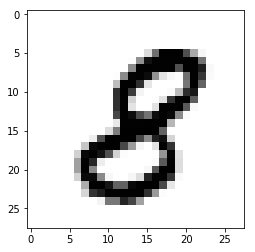

In [3]:
plt.imshow(mnist.train.images[5].reshape(28,28),cmap='Greys')

## The Networks

Here the activation function that we will use is what's called as the ***Leaky Rectified Linear Unit*** or ***Leaky Relu***

#### Leaky Relu  
It is an attempt to solve the dying ReLU problem. The ReLU function suffers from what is called the “dying ReLU” problem. Since the slope of the ReLU function on the negative side is zero, a neuron stuck on that side is unlikely to recover from it. This causes the neuron to output zero for every input, thus rendering it useless. A solution to this problem is to use Leaky ReLU which has a small slope on the negative side. The leak helps to increase the range of the ReLU function. Usually, the value of a is 0.01 or so.  
When a is not 0.01 then it is called Randomized ReLU.  
Therefore the range of the Leaky ReLU is (-infinity to infinity).  
Both Leaky and Randomized ReLU functions are monotonic in nature. Also, their derivatives also monotonic in nature.

![img](leaky_relu.jpeg)

### The Generator

In [4]:
def generator(z, reuse = None):
    with tf.variable_scope('gen', reuse = reuse):
        hidden1 = tf.layers.dense(inputs = z, units = 128)
        #Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs = hidden1, units = 128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        
        output = tf.layers.dense(hidden2, units = 784, activation = tf.nn.tanh)
        
        return output

### The Discriminator

In [5]:
def discriminator(X, reuse = None):
    with tf.variable_scope('dis', reuse = reuse):
        hidden1 = tf.layers.dense(inputs = X, units = 128)
        alpha = 0.01
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs = hidden1, units = 128)
        hidden2 = tf.maximum(alpha * hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units = 1)
        output = tf.sigmoid(logits)
        return output, logits

### Placeholders

In [6]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [7]:
G = generator(z)

### Discriminator 

In [8]:
D_output_real, D_logits_real = discriminator(real_images)
D_output_fake, D_logits_fake = discriminator(G, reuse = True)

### Losses

In [10]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

Now since we have to identify all the real images as true we create a tensor of ones for all the real images.  
The **tf.ones_like()** function allows us to directly just pass the tensor similar to the one that we want to create rather than the shape.

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.9))

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [18]:
batch_size = 100
epochs = 500
init = tf.global_variables_initializer()
saver = tf.train.Saver(var_list=g_vars)

In [19]:
# Save a sample per epoch
samples = []

In [20]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for e in range(epochs):
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Getting the batches of the images
            batch = mnist.train.next_batch(batch_size)
            
            # Getting the images and reshaping and rescaling
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 -1
            
            # Creating the random noise
            batch_z = np.random.uniform(-1 , 1, size = (batch_size, 100))
            
            # Running the optimizers no need to save the outputs as we won't be using them
            _ = sess.run(D_trainer, feed_dict  = {real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict = {z: batch_z})

            
        print("Currently on Epoch {} out of {}".format(e+1, epochs))
        
        #Sample from the generator
        sample_z = np.random.uniform(-1, 1, size = (1, 100))
        gen_sample = sess.run(generator(z, reuse = True), feed_dict = {z: sample_z})
        
        samples.append(gen_sample)
        saver.save(sess, './models/500_epoch_model.ckpt')

Currently on Epoch 1 of 500 total...
Currently on Epoch 2 of 500 total...
Currently on Epoch 3 of 500 total...
Currently on Epoch 4 of 500 total...
Currently on Epoch 5 of 500 total...
Currently on Epoch 6 of 500 total...
Currently on Epoch 7 of 500 total...
Currently on Epoch 8 of 500 total...
Currently on Epoch 9 of 500 total...
Currently on Epoch 10 of 500 total...
Currently on Epoch 11 of 500 total...
Currently on Epoch 12 of 500 total...
Currently on Epoch 13 of 500 total...
Currently on Epoch 14 of 500 total...
Currently on Epoch 15 of 500 total...
Currently on Epoch 16 of 500 total...
Currently on Epoch 17 of 500 total...
Currently on Epoch 18 of 500 total...
Currently on Epoch 19 of 500 total...
Currently on Epoch 20 of 500 total...
Currently on Epoch 21 of 500 total...
Currently on Epoch 22 of 500 total...
Currently on Epoch 23 of 500 total...
Currently on Epoch 24 of 500 total...
Currently on Epoch 25 of 500 total...
Currently on Epoch 26 of 500 total...
Currently on Epoch 27

Currently on Epoch 214 of 500 total...
Currently on Epoch 215 of 500 total...
Currently on Epoch 216 of 500 total...
Currently on Epoch 217 of 500 total...
Currently on Epoch 218 of 500 total...
Currently on Epoch 219 of 500 total...
Currently on Epoch 220 of 500 total...
Currently on Epoch 221 of 500 total...
Currently on Epoch 222 of 500 total...
Currently on Epoch 223 of 500 total...
Currently on Epoch 224 of 500 total...
Currently on Epoch 225 of 500 total...
Currently on Epoch 226 of 500 total...
Currently on Epoch 227 of 500 total...
Currently on Epoch 228 of 500 total...
Currently on Epoch 229 of 500 total...
Currently on Epoch 230 of 500 total...
Currently on Epoch 231 of 500 total...
Currently on Epoch 232 of 500 total...
Currently on Epoch 233 of 500 total...
Currently on Epoch 234 of 500 total...
Currently on Epoch 235 of 500 total...
Currently on Epoch 236 of 500 total...
Currently on Epoch 237 of 500 total...
Currently on Epoch 238 of 500 total...
Currently on Epoch 239 of

Currently on Epoch 425 of 500 total...
Currently on Epoch 426 of 500 total...
Currently on Epoch 427 of 500 total...
Currently on Epoch 428 of 500 total...
Currently on Epoch 429 of 500 total...
Currently on Epoch 430 of 500 total...
Currently on Epoch 431 of 500 total...
Currently on Epoch 432 of 500 total...
Currently on Epoch 433 of 500 total...
Currently on Epoch 434 of 500 total...
Currently on Epoch 435 of 500 total...
Currently on Epoch 436 of 500 total...
Currently on Epoch 437 of 500 total...
Currently on Epoch 438 of 500 total...
Currently on Epoch 439 of 500 total...
Currently on Epoch 440 of 500 total...
Currently on Epoch 441 of 500 total...
Currently on Epoch 442 of 500 total...
Currently on Epoch 443 of 500 total...
Currently on Epoch 444 of 500 total...
Currently on Epoch 445 of 500 total...
Currently on Epoch 446 of 500 total...
Currently on Epoch 447 of 500 total...
Currently on Epoch 448 of 500 total...
Currently on Epoch 449 of 500 total...
Currently on Epoch 450 of

In [21]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'./models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

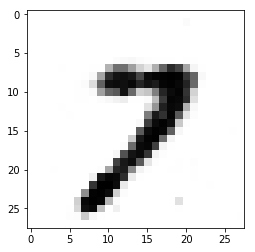

In [33]:
plt.imshow(samples[0].reshape(28,28),cmap='Greys')

### de nada!